# evaluation_4
## 3/21/24
This file contains the code to evaluate the models that do both classification and regression, we will implement a unique evals.utils file, that we can then put back in the evals.utils as a separate one for classification, or we just modify it to work regardless, that may be better, have to think of unique approaches

In [1]:
#first let's decide on which models to use
#we started training yesterday, so only 3 epochs on ctst model and 100 on multitasking, use most recent ctst, but can use any decent multitasking
#for the ctst it is
ctst_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-03-20/16-22-11-658258/checkpoints/02-val_loss=0.40410.ckpt'
#and for multitasking
multitasking_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-03-20/22-26-03-326937/checkpoints/138-val_loss=0.37743.ckpt'
#now let's define our utils


In [6]:

import torch
# import argparse
# import os
import sys
import yaml 
from tqdm import tqdm
# import json 
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
# from src.dataloaders.datasets.DNase_dataset import DNaseDataset
from src.tasks.decoders import SequenceDecoder
import pytorch_lightning as pl
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
from src.models.sequence.dna_embedding import DNAEmbeddingModel
from torch.utils.data import DataLoader
from src.dataloaders.datasets.ccre_dataset import CcreDataset
from src.models.sequence.long_conv_lm import ConvLMHeadModel

class Evals():
    def __init__(self, model_type, ckpt_path, filter=True, cfg = None, classification=True):
        #model type is like ccre, DNase, DNase_ctst etc.
        #ckpt_path is the path to the model checkpoint
        #filter is a boolean which is true if you want to filter the dataset to only include the cell types present in the training set
        #cfg is the path to the config file, if it's not provided, it will be inferred from the model type, but if you need a specific config, this is good to provide
        type_list = ['ccre', 'DNase_ctst', 'DNase_allcelltypes', 'DNase']
        if model_type not in type_list:
            raise ValueError('Model type not recognized')
        self.model_type = model_type   
        self.filter = filter
        self.classification = classification
        self.ckpt_path = ckpt_path
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.cfg = cfg #this is for if we want to define a separate one
        self.tokenizer = self.setup_tokenizer()
        self.setup_model()
        self.dataset = self.setup_dataset()
        
        
    def setup_tokenizer(self):
        model_type = self.model_type
        acgtn_list = ['ccre', 'DNase_ctst', 'DNase_allcelltypes']
        extra_list = ['DNase']
        if model_type in acgtn_list:
            tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            return tokenizer
        else:
            tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            return tokenizer
        
    def setup_model(self):
        model_type = self.model_type
        if model_type == 'ccre':
            cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/ccre.yaml'
            self.model = HG38Encoder(cfg, self.ckpt_path, 1024).eval()
        elif model_type == 'DNase_ctst':
            if self.classification:
                cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_ctst_classification.yaml'
            else:
                cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_ctst.yaml'
            self.regression_head(cfg, adjust_embedding=False) #new 171 dimensional vocab and lm head size
        elif model_type == 'DNase_allcelltypes':
            if self.classification:
                cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_allcelltypes_classification.yaml'
            else:
                cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_allcelltypes.yaml'
            self.regression_head(cfg, adjust_embedding=False) #original 16 dimensional vocab and lm head size
        elif model_type == 'DNase':
            cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase.yaml'
            self.regression_head(cfg, adjust_embedding=True) #20 dimensional input but 16 output lm size
    
    def setup_dataset(self):
        model_type = self.model_type
        if model_type == 'ccre':
            dataset = CcreDataset(max_length = 1024, split = 'test', tokenizer=self.tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True')
            return dataset
        elif model_type == 'DNase':
            from src.dataloaders.datasets.DNase_dataset import DNaseDataset
            dataset = DNaseDataset(max_length = 1024, split = 'test', tokenizer=self.tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True', filter = self.filter, classification=self.classification)
            return dataset
        elif model_type == 'DNase_ctst':
            from src.dataloaders.datasets.DNase_ctst_dataset import DNaseCtstDataset
            dataset = DNaseCtstDataset(max_length = 1024, split = 'test', tokenizer=self.tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True', filter = self.filter, classification=self.classification)
            return dataset
        elif model_type == 'DNase_allcelltypes':
            from src.dataloaders.datasets.DNase_allcelltypes import DNaseAllCellTypeDataset
            dataset = DNaseAllCellTypeDataset(max_length = 1024, split = 'test', tokenizer=self.tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True', filter = self.filter, classification=self.classification)
            return dataset
        
    def regression_head(self, cfg, adjust_embedding=False):
        if self.cfg is None:
            cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
        else:
            cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/' + self.cfg
            cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
        train_cfg = cfg['train']  # grab section `train` section of config
        model_cfg = cfg['model_config']  # grab the `model` section of config
        d_output = train_cfg['d_output']  #TODO make it so that we just adjust this with self.classificaiton, no need for evals
        backbone = DNAEmbeddingModel(**model_cfg)
        decoder = SequenceDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')
        state_dict = torch.load(self.ckpt_path, map_location='cpu')  # has both backbone and decoder
        # loads model from ddp by removing prexix to single if necessary
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )
        model_state_dict = state_dict["state_dict"]
        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)
        # the state_dict keys slightly mismatch from Lightning..., so we fix it here
        decoder_state_dict = {}
        decoder_state_dict['output_transform.weight'] = model_state_dict.pop('decoder.0.output_transform.weight')
        decoder_state_dict['output_transform.bias'] = model_state_dict.pop('decoder.0.output_transform.bias')
        if adjust_embedding:
            embedding = torch.nn.Embedding(20, 128)
            backbone.backbone.embeddings.word_embeddings = embedding
        # now actually load the state dict to the decoder and backbone separately
        decoder.load_state_dict(decoder_state_dict, strict=True)
        backbone.load_state_dict(model_state_dict, strict=True)
        self.decoder = decoder.to(self.device).eval()
        self.backbone = backbone.to(self.device).eval()
        
    def evaluate(self, batch_size=4096, num_workers=4):
        if self.model_type == 'ccre':
            targets = torch.zeros((len(self.dataset), 1023))
            predicts = torch.zeros((len(self.dataset), 1023))
            ccre = DataLoader(self.dataset, batch_size=4096, shuffle=False, num_workers=4) #results are identical even if you shuffle, obviously since it's just the mean
            with torch.no_grad():
                idx = 0
                for i, batch in tqdm(enumerate(ccre), total = len(ccre)):
                    seq, target = batch
                    seq = seq.unsqueeze(0)
                    seq = seq.to(self.device)
                    b_size = seq.shape[0]
                    y_hat = self.model.encode(seq)
                    y_hat = y_hat[0].logits[0,:,:]
                    targets[idx:b_size+idx,:] = target
                    predicts[idx:b_size+idx,:] = y_hat.detach().cpu()
                    idx += b_size
        elif self.model_type == 'DNase' or self.model_type == 'DNase_ctst': #this does the flatten then reshape
            targets_flat = torch.zeros(len(self.dataset)) #because output is just a single value, it's so obvious it's kind of stupid
            predicts_flat = torch.zeros(len(self.dataset))
            DNase = DataLoader(self.dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers) #results are identical even if you shuffle, obviously since it's just the mean
            with torch.no_grad():
                idx = 0
                for i, batch in tqdm(enumerate(DNase), total = len(DNase)):
                    seq, target = batch
                    seq = seq.to(self.device)
                    b_size = seq.shape[0]
                    # target = target.to(device)
                    y_hat, _ = self.backbone(seq)
                    y_hat = self.decoder(y_hat)
                    # print(y_hat)
                    # print(target)
                    targets_flat[idx:b_size+idx] = target.squeeze()
                    predicts_flat[idx:b_size+idx] = y_hat.detach().cpu().squeeze()
                    idx += b_size
                    # if i == 5:
                    #     break
            targets = targets_flat.reshape(-1, self.dataset.cell_types)
            predicts = predicts_flat.reshape(-1, self.dataset.cell_types)
            return targets, predicts
        elif self.model_type == 'DNase_allcelltypes':
            targets = torch.zeros((len(self.dataset), 161))
            predicts = torch.zeros((len(self.dataset), 161))
            DNase = DataLoader(self.dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers) #results are identical even if you shuffle, obviously since it's just the mean
            with torch.no_grad():
                idx = 0
                for i, batch in tqdm(enumerate(DNase), total = len(DNase)):
                    seq, target = batch
                    seq = seq.to(self.device)
                    b_size = seq.shape[0]
                    # target = target.to(device)
                    y_hat, _ = self.backbone(seq)
                    y_hat = self.decoder(y_hat)
                    # print(y_hat)
                    # print(target)
                    targets[idx:b_size+idx,:] = target
                    predicts[idx:b_size+idx,:] = y_hat.detach().cpu()
                    idx += b_size
            return targets, predicts

In [7]:
#have to adjust the eval function, but for now let's test to see if we can load
ctst = Evals('DNase_ctst', ctst_path, filter=True, classification=True)
#let's check the model
ctst.backbone

DNAEmbeddingModel(
  (backbone): LMBackbone(
    (embeddings): GPT2Embeddings(
      (word_embeddings): Embedding(180, 128)
    )
    (layers): ModuleList(
      (0): Block(
        (mixer): HyenaOperator(
          (activation): Identity()
          (dropout): Dropout(p=0.0, inplace=False)
          (out_proj): Linear(in_features=128, out_features=128, bias=True)
          (in_proj): Linear(in_features=128, out_features=384, bias=True)
          (short_filter): Conv1d(384, 384, kernel_size=(3,), stride=(1,), padding=(2,), groups=384)
          (filter_fn): HyenaFilter(
            (dropout): Dropout(p=0.0, inplace=False)
            (pos_emb): PositionalEmbedding()
            (implicit_filter): Sequential(
              (0): Linear(in_features=5, out_features=64, bias=True)
              (1): Sin()
              (2): Linear(in_features=64, out_features=64, bias=True)
              (3): Sin()
              (4): Linear(in_features=64, out_features=64, bias=True)
              (5): Sin(

In [8]:
a,b = ctst.dataset[0]
print(b)

(tensor([0]), tensor([-10.]))


In [9]:
out,_ = ctst.backbone(a.unsqueeze(0))
out2 = ctst.decoder(out)
print(out2)
#a really bad prediction because it is saying a high number when should be low...

tensor([[3.7671, 0.5146]], grad_fn=<AddmmBackward0>)


In [11]:
#since it's closed, we never calculated mse
#but now let's try the multitasking model
multitasking = Evals('DNase_allcelltypes', multitasking_path, filter=True, classification=True)
multitasking.backbone

DNAEmbeddingModel(
  (backbone): LMBackbone(
    (embeddings): GPT2Embeddings(
      (word_embeddings): Embedding(16, 128)
    )
    (layers): ModuleList(
      (0): Block(
        (mixer): HyenaOperator(
          (activation): Identity()
          (dropout): Dropout(p=0.0, inplace=False)
          (out_proj): Linear(in_features=128, out_features=128, bias=True)
          (in_proj): Linear(in_features=128, out_features=384, bias=True)
          (short_filter): Conv1d(384, 384, kernel_size=(3,), stride=(1,), padding=(2,), groups=384)
          (filter_fn): HyenaFilter(
            (dropout): Dropout(p=0.0, inplace=False)
            (pos_emb): PositionalEmbedding()
            (implicit_filter): Sequential(
              (0): Linear(in_features=5, out_features=64, bias=True)
              (1): Sin()
              (2): Linear(in_features=64, out_features=64, bias=True)
              (3): Sin()
              (4): Linear(in_features=64, out_features=64, bias=True)
              (5): Sin()

In [12]:
a,b = multitasking.dataset[0]
print(b)

(tensor([0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]), tensor([-1.0000e+01, -4.5808e-01, -1.0000e+01, -1.0000e+01, -1.8792e+00,
        -1.0000e+01, -2.3478e+00, -1.8173e+00, -6.1973e-01, -3.1970e+00,
        -3.1362e+00, -6.3732e-01, -1.0000e+01, -1.0000e+01, -1.0000e+01,
        -1.0000e+01, -1.0000e+01, -1.0000e+01, -1.0000e+01, -1.6359e+00,
        -2.9812e+00, -1.0000e+01, -1.0000e+01, -1.9674e+00, -1.0000e+01,
        -1.0000e+01, -1.0000e+01, -1.1343e+00, -1.4971e+00, -1.0000e+01,
        -1.0000e+01,

In [14]:
out,_ = multitasking.backbone(a.unsqueeze(0))
out2 = multitasking.decoder(out)
print(out2[0]) #for the 0th one, 1.3 is much better...

tensor([ 1.3113e+00,  1.0276e+00,  2.4768e+00,  3.5758e+00,  3.2231e+00,
         3.1419e+00,  4.0295e+00,  3.1059e+00,  2.3982e+00,  3.9641e+00,
         3.5131e+00,  1.7574e+00,  1.5665e+00,  3.9942e+00,  3.3422e+00,
         1.4613e+00,  1.6208e+00,  1.8042e+00,  1.1558e+00,  3.8076e+00,
         3.3139e+00,  1.6151e+00,  2.5940e+00,  2.3656e+00,  2.2174e+00,
         3.8411e-01,  3.4716e+00,  1.1116e+00,  2.4532e+00,  4.0679e-01,
         3.7172e+00,  7.6932e-01,  2.7121e+00,  2.5579e-01,  2.6654e+00,
         2.9993e+00,  3.2487e+00,  5.2166e+00,  1.4840e+00,  1.7232e+00,
         1.0848e+00,  7.1434e-01,  1.4387e+00,  1.1965e+00, -1.0544e-01,
         2.4211e+00,  1.9824e+00,  1.6224e+00,  1.6123e+00,  1.0640e+00,
         9.6699e-01,  3.3873e+00,  2.0803e+00,  4.1015e+00,  1.9808e+00,
         3.4188e+00,  4.1627e+00,  4.1555e+00,  2.8186e+00,  1.4098e+00,
         4.4016e+00,  4.4631e+00,  3.0001e+00,  4.3283e+00,  2.2662e+00,
         5.6704e+00,  5.0758e+00,  3.9410e+00,  1.4

In [16]:
out2.shape

torch.Size([1, 322])

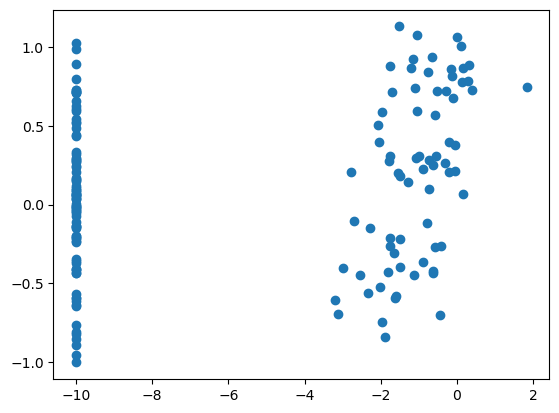

In [18]:
#now we have the models, let's see how we would need to evaluate them
#let's think of a baseline, we can do auc or something?
#let's plot the predicted vs actual for the multitasking model on the regression
import matplotlib.pyplot as plt
plt.scatter(b[1], out2[0,161:].detach().cpu().numpy())

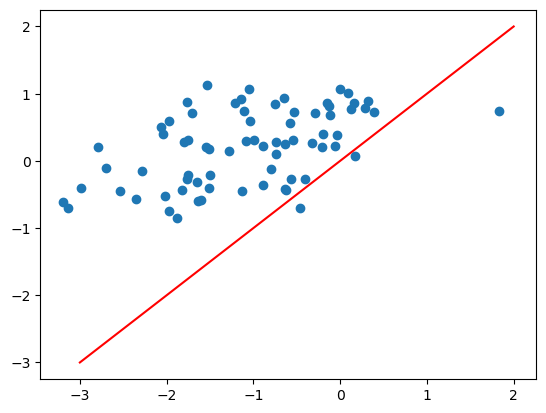

In [21]:
#remove the -10 values
mask = b[1] != -10
plt.scatter(b[1][mask], out2[0,161:][mask].detach().cpu().numpy())
#and regression 1,1, line
plt.plot([-3,2],[-3,2], color='red')
#we can see for this ccre it does mostly suck

In [23]:
#let's do a confusion matrix for the classification
from sklearn.metrics import confusion_matrix
import numpy as np
#let's do the first one
y_true = b[0].detach().cpu().numpy()
y_pred = out2[0,:161].detach().cpu().numpy()
#the threshold is 0 for now
y_pred = np.where(y_pred > 0, 1, 0)
cm = confusion_matrix(y_true, y_pred)

In [25]:
cm

array([[ 1, 88],
       [ 0, 72]])

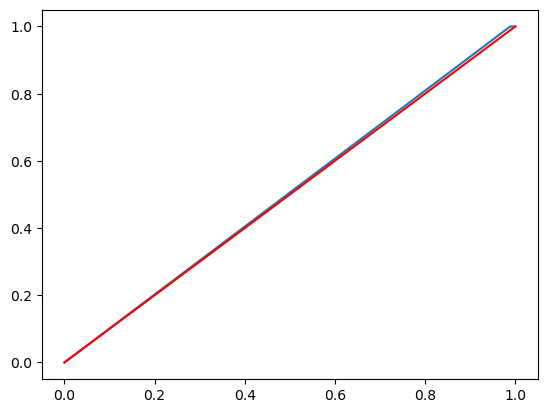

In [26]:
#let's try an roc curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], color='red')
# that is literally right on the 0,1 line... that's very bad!

In [33]:
#let's try this for the ctst model
real_class = []
real_reg = []
pred_class = []
pred_reg = []
for i in range(161):
    a,b = ctst.dataset[i]
    out,_ = ctst.backbone(a.unsqueeze(0))
    out2 = ctst.decoder(out).squeeze()
    # print(out.shape)
    real_class.append(b[0].detach().cpu().numpy())
    real_reg.append(b[1].detach().cpu().numpy())
    pred_reg.append(out2[1].detach().cpu().numpy())
    pred_class.append(out2[0].detach().cpu().numpy())

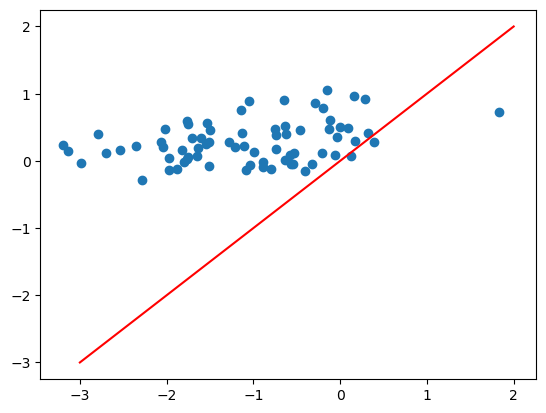

In [37]:
#now let's do regression
mask = np.array(real_reg) != -10
mask = mask.squeeze()
mask_real = np.array(real_reg)[mask]
mask_pred = np.array(pred_reg)[mask]
plt.plot(mask_real, mask_pred, 'o')
#and regression 1,1, line
plt.plot([-3,2],[-3,2], color='red')

In [39]:
#and cm
y_true = np.array(real_class).flatten()
y_pred = np.array(pred_class).flatten()
y_pred = np.where(y_pred > 0, 1, 0)
cm = confusion_matrix(y_true, y_pred)
cm

array([[ 0, 89],
       [ 0, 72]])

In [47]:
print(real_class)
print(np.array(real_class).shape)
print(np.array(real_class).flatten().shape)

[array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([1]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([0]), array([1]), array([1]), array([0]), array([0]), array([0]), array([1]), array([0]), array([0]), array([1]), array([1]), array([1]), array([1]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([1]), array([1]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([1]), array([1]), array([0]), array([0]), array([0]), array([0]), array([0]), array([1]), array([0]), arr

[[ 4 71]
 [ 0 86]]


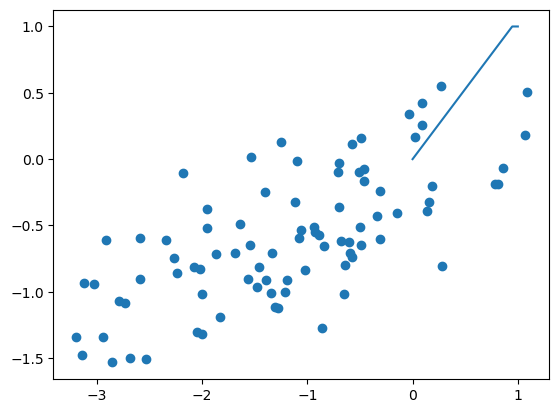

In [50]:
#this is really bad, let's see how the next ccre is
a,b = multitasking.dataset[1]
out,_ = multitasking.backbone(a.unsqueeze(0))
out2 = multitasking.decoder(out)
mask = b[1] != -10
plt.scatter(b[1][mask], out2[0,161:][mask].detach().cpu().numpy())
# plt.plot([-3,2],[-3,2], color='red')
#we can see for this ccre it does mostly suck
#let's do a confusion matrix for the classification
#let's do the first one
y_true = b[0].detach().cpu().numpy()
y_pred = out2[0,:161].detach().cpu().numpy()
#the threshold is 0 for now
y_pred = np.where(y_pred > 0, 1, 0)
cm = confusion_matrix(y_true, y_pred)
print(cm)
#let's try an roc curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr)
# plt.plot([0,1],[0,1], color='red')
# that is literally right on the 0,1 line... that's very bad!

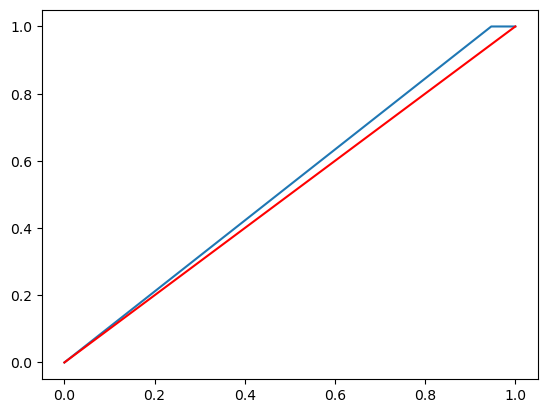

In [59]:
#and roc
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], color='red')
#that's also really bad, it's the 0,1 line

In [60]:
#find the auc
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true, y_pred)
#oh god...

0.5266666666666666

In [54]:
from icecream import ic
ic(y_true)
ic(y_pred)

ic| y_true: array([0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
                   0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
                   0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
                   1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
                   1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
                   0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
                   1, 1, 1, 0, 0, 1, 1])
ic| y_pred: array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
                   0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1,

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

In [57]:
print(out2[0,:161].detach().cpu().numpy())

[ 0.910824    1.2558777   2.4029753   3.2680554   3.262619    2.804256
  3.5543451   2.7804961   1.8730447   3.7445486   3.479189    1.6740255
  1.6501521   3.735212    3.4148295   1.3095558   1.2819684   1.5438032
  0.7256227   3.4055667   3.2870147   1.6660674   2.3312614   2.1868112
  2.051857    0.35353088  2.6901278   1.0601867   2.0740273   0.7415642
  3.0978518   0.64912367  2.5373118   0.17148133  2.4581728   3.2919354
  2.952386    4.0435095   0.11508785  0.48928943 -0.02641942 -0.18345077
  0.30343434  0.57666945 -0.25261837  1.1773988   1.0293881   0.6405176
  0.55249333  0.52214867  0.08532227  3.479997    0.9820168   5.329087
  1.1972818   1.7238861   4.4306393   3.620887    1.298208    1.08733
  4.1307645   3.7710478   1.2534729   3.485188    1.1620421   5.3433847
  5.867626    4.4795055   1.5606143   0.03122206  0.9285956   5.5417786
  0.03567004  1.2816051   4.152771    4.251111    4.707676    4.3046165
  0.44952857 -0.1630093   0.09764364  5.636457    5.077259    4.677

100%|██████████| 10000/10000 [06:45<00:00, 24.67it/s]


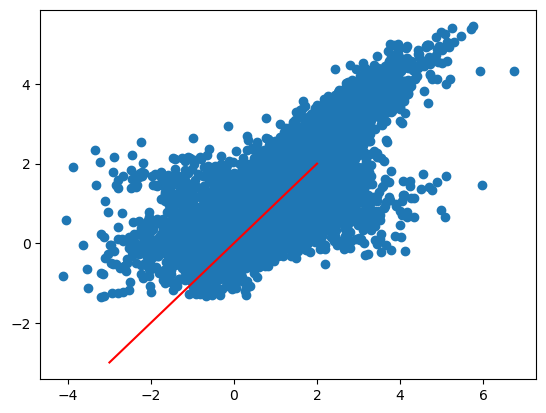

In [61]:
#this is really bad, sure only 2 epochs, but... it's not promising in the slightest!
#let's try evaluating it for a bunch of them
#let's try this for the ctst model
real_class = []
real_reg = []
pred_class = []
pred_reg = []
for i in tqdm(range(10000)):
    a,b = ctst.dataset[i]
    out,_ = ctst.backbone(a.unsqueeze(0))
    out2 = ctst.decoder(out).squeeze()
    # print(out.shape)
    real_class.append(b[0].detach().cpu().numpy())
    real_reg.append(b[1].detach().cpu().numpy())
    pred_reg.append(out2[1].detach().cpu().numpy())
    pred_class.append(out2[0].detach().cpu().numpy())
#now let's do regression
mask = np.array(real_reg) != -10
mask = mask.squeeze()
mask_real = np.array(real_reg)[mask]
mask_pred = np.array(pred_reg)[mask]
plt.plot(mask_real, mask_pred, 'o')
#and regression 1,1, line
plt.plot([-3,2],[-3,2], color='red')

In [62]:
#seems somewhat reasonable, now let's do classification
y_true = np.array(real_class).flatten()
y_pred = np.array(pred_class).flatten()
y_pred = np.where(y_pred > 0, 1, 0)
cm = confusion_matrix(y_true, y_pred)
cm

array([[   5,  437],
       [   2, 9556]])

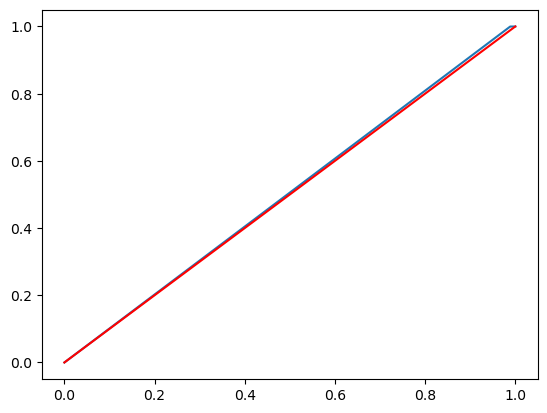

In [63]:
#just a lot of open ones and tends to favor predicting open lol
#now let's see the roc curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], color='red')
#yeah, exactly as we expected...

In [ ]:
#let's work on making that evaluation utils
def evaluate(self, batch_size=4096, num_workers=4):
    if self.model_type == 'ccre':
        targets = torch.zeros((len(self.dataset), 1023))
        predicts = torch.zeros((len(self.dataset), 1023))
        ccre = DataLoader(self.dataset, batch_size=4096, shuffle=False, num_workers=4) #results are identical even if you shuffle, obviously since it's just the mean
        with torch.no_grad():
            idx = 0
            for i, batch in tqdm(enumerate(ccre), total = len(ccre)):
                seq, target = batch
                seq = seq.unsqueeze(0)
                seq = seq.to(self.device)
                b_size = seq.shape[0]
                y_hat = self.model.encode(seq)
                y_hat = y_hat[0].logits[0,:,:]
                targets[idx:b_size+idx,:] = target
                predicts[idx:b_size+idx,:] = y_hat.detach().cpu()
                idx += b_size
    elif self.model_type == 'DNase' or self.model_type == 'DNase_ctst': #this does the flatten then reshape
        targets_flat = torch.zeros(len(self.dataset)) #because output is just a single value, it's so obvious it's kind of stupid
        predicts_flat = torch.zeros(len(self.dataset))
        targets_class_flat = torch.zeros(len(self.dataset))
        predicts_class_flat = torch.zeros(len(self.dataset))
        DNase = DataLoader(self.dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers) #results are identical even if you shuffle, obviously since it's just the mean
        with torch.no_grad():
            idx = 0
            for i, batch in tqdm(enumerate(DNase), total = len(DNase)):
                seq, target = batch
                seq = seq.to(self.device)
                b_size = seq.shape[0]
                y_hat, _ = self.backbone(seq)
                y_hat = self.decoder(y_hat)
                if self.classification:
                    targets_flat[idx:b_size+idx] = target[1].squeeze()
                    targets_class_flat[idx:b_size+idx] = target[0].squeeze()
                    predicts_flat[idx:b_size+idx] = y_hat[:,1].detach().cpu().squeeze() #note the .squeeze not necessary
                    predicts_class_flat[idx:b_size+idx] = y_hat[:,0].detach().cpu().squeeze()
                else:
                    targets_flat[idx:b_size+idx] = target.squeeze()
                    predicts_flat[idx:b_size+idx] = y_hat.detach().cpu().squeeze()
                idx += b_size
                # if i == 5:
                #     break
        targets = targets_flat.reshape(-1, self.dataset.cell_types)
        predicts = predicts_flat.reshape(-1, self.dataset.cell_types)
        targets2 = targets_class_flat.reshape(-1, self.dataset.cell_types)
        predicts2 = predicts_class_flat.reshape(-1, self.dataset.cell_types)
        if self.classification:
            targets = (targets2, targets)
            predicts = (predicts2, predicts)
        return targets, predicts
    elif self.model_type == 'DNase_allcelltypes':
        targets = torch.zeros((len(self.dataset), 161))
        predicts = torch.zeros((len(self.dataset), 161))
        DNase = DataLoader(self.dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers) #results are identical even if you shuffle, obviously since it's just the mean
        with torch.no_grad():
            idx = 0
            for i, batch in tqdm(enumerate(DNase), total = len(DNase)):
                seq, target = batch
                seq = seq.to(self.device)
                b_size = seq.shape[0]
                # target = target.to(device)
                y_hat, _ = self.backbone(seq)
                y_hat = self.decoder(y_hat)
                # print(y_hat)
                # print(target)
                targets[idx:b_size+idx,:] = target
                predicts[idx:b_size+idx,:] = y_hat.detach().cpu()
                idx += b_size
        return targets, predicts

In [65]:
loader = DataLoader(ctst.dataset, batch_size=64, shuffle=False, num_workers=1)
for i, batch in enumerate(loader):
    print(i)
    print(batch)
    if i == 0:
        break
print(batch.shape)

0
[tensor([[12,  8,  7,  ...,  9,  7,  8],
        [13,  8,  7,  ...,  9,  7,  8],
        [14,  8,  7,  ...,  9,  7,  8],
        ...,
        [73,  8,  7,  ...,  9,  7,  8],
        [74,  8,  7,  ...,  9,  7,  8],
        [75,  8,  7,  ...,  9,  7,  8]]), [tensor([[0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],


AttributeError: 'list' object has no attribute 'shape'

In [66]:
seq,target = batch
seq.shape

torch.Size([64, 1024])

In [68]:
#run seq through
out,_ = ctst.backbone(seq)
out2 = ctst.decoder(out)
print(out2.shape)

torch.Size([64, 2])


In [69]:
out2[:,0].shape

torch.Size([64])

In [67]:
target1,target2 = target
print(target1.shape,target2.shape)

torch.Size([64, 1]) torch.Size([64, 1])


In [94]:
#now let's test this full class

import torch
# import argparse
# import os
import sys
import yaml 
from tqdm import tqdm
# import json 
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
# from src.dataloaders.datasets.DNase_dataset import DNaseDataset
from src.tasks.decoders import SequenceDecoder
import pytorch_lightning as pl
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
from src.models.sequence.dna_embedding import DNAEmbeddingModel
from torch.utils.data import DataLoader
from src.dataloaders.datasets.ccre_dataset import CcreDataset
from src.models.sequence.long_conv_lm import ConvLMHeadModel

class Evals():
    def __init__(self, model_type, ckpt_path, filter=True, cfg = None, classification=True):
        #model type is like ccre, DNase, DNase_ctst etc.
        #ckpt_path is the path to the model checkpoint
        #filter is a boolean which is true if you want to filter the dataset to only include the cell types present in the training set
        #cfg is the path to the config file, if it's not provided, it will be inferred from the model type, but if you need a specific config, this is good to provide
        type_list = ['ccre', 'DNase_ctst', 'DNase_allcelltypes', 'DNase']
        if model_type not in type_list:
            raise ValueError('Model type not recognized')
        self.model_type = model_type   
        self.filter = filter
        self.classification = classification
        self.ckpt_path = ckpt_path
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.cfg = cfg #this is for if we want to define a separate one
        self.tokenizer = self.setup_tokenizer()
        self.setup_model()
        self.dataset = self.setup_dataset()
        
        
    def setup_tokenizer(self):
        model_type = self.model_type
        acgtn_list = ['ccre', 'DNase_ctst', 'DNase_allcelltypes']
        extra_list = ['DNase']
        if model_type in acgtn_list:
            tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            return tokenizer
        else:
            tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            return tokenizer
        
    def setup_model(self):
        model_type = self.model_type
        if model_type == 'ccre':
            cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/ccre.yaml'
            self.model = HG38Encoder(cfg, self.ckpt_path, 1024).eval()
        elif model_type == 'DNase_ctst':
            if self.classification:
                cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_ctst_classification.yaml'
            else:
                cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_ctst.yaml'
            self.regression_head(cfg, adjust_embedding=False) #new 171 dimensional vocab and lm head size
        elif model_type == 'DNase_allcelltypes':
            if self.classification:
                cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_allcelltypes_classification.yaml'
            else:
                cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_allcelltypes.yaml'
            self.regression_head(cfg, adjust_embedding=False) #original 16 dimensional vocab and lm head size
        elif model_type == 'DNase':
            cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase.yaml'
            self.regression_head(cfg, adjust_embedding=True) #20 dimensional input but 16 output lm size
    
    def setup_dataset(self):
        model_type = self.model_type
        if model_type == 'ccre':
            dataset = CcreDataset(max_length = 1024, split = 'test', tokenizer=self.tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True')
            return dataset
        elif model_type == 'DNase':
            from src.dataloaders.datasets.DNase_dataset import DNaseDataset
            dataset = DNaseDataset(max_length = 1024, split = 'test', tokenizer=self.tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True', filter = self.filter, classification=self.classification)
            return dataset
        elif model_type == 'DNase_ctst':
            from src.dataloaders.datasets.DNase_ctst_dataset import DNaseCtstDataset
            dataset = DNaseCtstDataset(max_length = 1024, split = 'test', tokenizer=self.tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True', filter = self.filter, classification=self.classification)
            return dataset
        elif model_type == 'DNase_allcelltypes':
            from src.dataloaders.datasets.DNase_allcelltypes import DNaseAllCellTypeDataset
            dataset = DNaseAllCellTypeDataset(max_length = 1024, split = 'test', tokenizer=self.tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True', filter = self.filter, classification=self.classification)
            return dataset
        
    def regression_head(self, cfg, adjust_embedding=False):
        if self.cfg is None:
            cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
        else:
            cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/' + self.cfg
            cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
        train_cfg = cfg['train']  # grab section `train` section of config
        model_cfg = cfg['model_config']  # grab the `model` section of config
        d_output = train_cfg['d_output']  #TODO make it so that we just adjust this with self.classificaiton, no need for evals
        backbone = DNAEmbeddingModel(**model_cfg)
        decoder = SequenceDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')
        state_dict = torch.load(self.ckpt_path, map_location='cpu')  # has both backbone and decoder
        # loads model from ddp by removing prexix to single if necessary
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )
        model_state_dict = state_dict["state_dict"]
        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)
        # the state_dict keys slightly mismatch from Lightning..., so we fix it here
        decoder_state_dict = {}
        decoder_state_dict['output_transform.weight'] = model_state_dict.pop('decoder.0.output_transform.weight')
        decoder_state_dict['output_transform.bias'] = model_state_dict.pop('decoder.0.output_transform.bias')
        if adjust_embedding:
            embedding = torch.nn.Embedding(20, 128)
            backbone.backbone.embeddings.word_embeddings = embedding
        # now actually load the state dict to the decoder and backbone separately
        decoder.load_state_dict(decoder_state_dict, strict=True)
        backbone.load_state_dict(model_state_dict, strict=True)
        self.decoder = decoder.to(self.device).eval()
        self.backbone = backbone.to(self.device).eval()
#let's work on making that evaluation utils
    def evaluate(self, batch_size=4096, num_workers=4):
        if self.model_type == 'ccre':
            targets = torch.zeros((len(self.dataset), 1023))
            predicts = torch.zeros((len(self.dataset), 1023))
            ccre = DataLoader(self.dataset, batch_size=4096, shuffle=False, num_workers=4) #results are identical even if you shuffle, obviously since it's just the mean
            with torch.no_grad():
                idx = 0
                for i, batch in tqdm(enumerate(ccre), total = len(ccre)):
                    seq, target = batch
                    seq = seq.unsqueeze(0)
                    seq = seq.to(self.device)
                    b_size = seq.shape[0]
                    y_hat = self.model.encode(seq)
                    y_hat = y_hat[0].logits[0,:,:]
                    targets[idx:b_size+idx,:] = target
                    predicts[idx:b_size+idx,:] = y_hat.detach().cpu()
                    idx += b_size
        elif self.model_type == 'DNase' or self.model_type == 'DNase_ctst': #this does the flatten then reshape
            targets_flat = torch.zeros(len(self.dataset)) #because output is just a single value, it's so obvious it's kind of stupid
            predicts_flat = torch.zeros(len(self.dataset))
            targets_class_flat = torch.zeros(len(self.dataset))
            predicts_class_flat = torch.zeros(len(self.dataset))
            DNase = DataLoader(self.dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers) #results are identical even if you shuffle, obviously since it's just the mean
            with torch.no_grad():
                idx = 0
                for i, batch in tqdm(enumerate(DNase), total = len(DNase)):
                    seq, target = batch
                    seq = seq.to(self.device)
                    b_size = seq.shape[0]
                    y_hat, _ = self.backbone(seq)
                    y_hat = self.decoder(y_hat)
                    if self.classification:
                        targets_flat[idx:b_size+idx] = target[1].squeeze()
                        targets_class_flat[idx:b_size+idx] = target[0].squeeze()
                        predicts_flat[idx:b_size+idx] = y_hat[:,1].detach().cpu().squeeze() #note the .squeeze not necessary
                        predicts_class_flat[idx:b_size+idx] = y_hat[:,0].detach().cpu().squeeze()
                    else:
                        targets_flat[idx:b_size+idx] = target.squeeze()
                        predicts_flat[idx:b_size+idx] = y_hat.detach().cpu().squeeze()
                    idx += b_size
                    # if i == 5:
                    #     break
            targets = targets_flat.reshape(-1, self.dataset.cell_types)
            predicts = predicts_flat.reshape(-1, self.dataset.cell_types)
            targets2 = targets_class_flat.reshape(-1, self.dataset.cell_types)
            predicts2 = predicts_class_flat.reshape(-1, self.dataset.cell_types)
            if self.classification:
                targets = (targets2, targets)
                predicts = (predicts2, predicts)
            return targets, predicts
        elif self.model_type == 'DNase_allcelltypes':
            targets = torch.zeros((len(self.dataset), 161))
            predicts = torch.zeros((len(self.dataset), 161))
            targets_class = torch.zeros((len(self.dataset), 161))
            predicts_class = torch.zeros((len(self.dataset), 161))
            DNase = DataLoader(self.dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers) #results are identical even if you shuffle, obviously since it's just the mean
            with torch.no_grad():
                idx = 0
                for i, batch in tqdm(enumerate(DNase), total = len(DNase)):
                    seq, target = batch
                    seq = seq.to(self.device)
                    b_size = seq.shape[0]
                    # target = target.to(device)
                    y_hat, _ = self.backbone(seq)
                    y_hat = self.decoder(y_hat)
                    # print(y_hat)
                    # print(target)
                    if self.classification:
                        targets_class[idx:b_size+idx,:] = target[0]
                        predicts_class[idx:b_size+idx,:] = y_hat[:,:161].detach().cpu()
                        targets[idx:b_size+idx,:] = target[1]
                        predicts[idx:b_size+idx,:] = y_hat[:,161:].detach().cpu()
                    else:
                        targets[idx:b_size+idx,:] = target
                        predicts[idx:b_size+idx,:] = y_hat.detach().cpu()
                    idx += b_size
                    # if i == 5:
                    #     break
            if self.classification:
                targets = (targets_class, targets)
                predicts = (predicts_class, predicts)
            return targets, predicts

In [75]:
ctst = Evals('DNase_ctst', ctst_path, filter=True, classification=True)
targets,predicts = ctst.evaluate(batch_size = 64, num_workers = 1)

  0%|          | 5/264775 [00:15<231:15:32,  3.14s/it]


In [76]:
#let's make sure it actually worked! only the first 5 batches are going to be done
len(targets)

2

In [77]:
targets[0].shape
#this is about 64*264775/161, it's basically exactly that shape, so we're probably correct

torch.Size([105252, 161])

In [82]:
#so if it's filling the first 161 each time, expect to see the first 64*5 filled which is 320, so almost the second row
targets[1][1] #wait why is the entire second one filled? oh wait no it actually did 6 because breaks when it's 5!!

tensor([-10.0000,  -1.1888, -10.0000,  -2.6834, -10.0000, -10.0000, -10.0000,
        -10.0000, -10.0000,  -3.1970,  -3.1362,  -0.6400, -10.0000,  -2.7933,
        -10.0000, -10.0000, -10.0000, -10.0000, -10.0000,  -2.9364, -10.0000,
        -10.0000, -10.0000, -10.0000, -10.0000, -10.0000, -10.0000, -10.0000,
        -10.0000, -10.0000,  -1.9988, -10.0000, -10.0000, -10.0000, -10.0000,
         -2.0236,  -2.5367, -10.0000, -10.0000,  -0.6557, -10.0000, -10.0000,
        -10.0000, -10.0000, -10.0000,  -0.4904, -10.0000, -10.0000, -10.0000,
        -10.0000, -10.0000,   1.0666,   0.1828,   0.7807,  -0.4622,  -0.5024,
         -1.3944, -10.0000, -10.0000, -10.0000,  -1.4567,  -1.5473,   0.2794,
         -1.5674,   0.1411,  -1.2771,  -1.8280,  -1.3054, -10.0000, -10.0000,
        -10.0000,  -1.2153, -10.0000, -10.0000,  -1.3412,  -1.8704, -10.0000,
        -10.0000, -10.0000, -10.0000, -10.0000,  -2.5884, -10.0000,  -1.2475,
         -0.9299,  -1.9488,  -0.5997,  -1.9992,  -0.9325, -10.00

In [83]:
targets[1][2,60:64] #now we expect it to go to 384, which is number 62, so should be index 61, so let's do 60:64
#first should have value and next, but not third, and it's exactly like we expected! So fills it in the way we want!!

tensor([0.7598, 0.6773, 0.0000, 0.0000])

In [84]:
predicts[1][2,60:64] #let's see if it's the same for the predicts, and it is, and the predictions kinda nice?

tensor([0.8470, 0.9340, 0.0000, 0.0000])

# now let's do the multitasking one

In [95]:
multitasking = Evals('DNase_allcelltypes', multitasking_path, filter=True, classification=True)
#first let's verify shapes and sizes
#first let's ensure that the sizes of it line up
loader = DataLoader(multitasking.dataset, batch_size=64, shuffle=False, num_workers=1)
for i, batch in enumerate(loader):
    print(i)
    print(batch)
    if i == 0:
        break

0
[tensor([[ 8,  7,  9,  ...,  9,  7,  8],
        [10,  8,  8,  ...,  7, 10, 10],
        [10,  8,  8,  ...,  8,  7,  8],
        ...,
        [ 8,  8,  9,  ...,  8,  9,  8],
        [ 7,  8,  9,  ..., 10, 10,  8],
        [ 8, 10,  9,  ...,  8,  8,  7]]), [tensor([[0, 1, 0,  ..., 0, 1, 0],
        [0, 1, 0,  ..., 0, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 1, 1]]), tensor([[-10.0000,  -0.4581, -10.0000,  ..., -10.0000,  -1.7576, -10.0000],
        [-10.0000,  -1.1888, -10.0000,  ..., -10.0000,  -3.0268,  -2.2397],
        [  0.2071,   1.3613,  -2.4325,  ...,  -0.7399,   4.2481,  -0.7007],
        ...,
        [  2.2684,   2.4656,   1.3764,  ..., -10.0000,   0.6194,  -0.8016],
        [  1.7570,   1.9776,   0.3576,  ...,  -0.1018,   0.3272,  -1.5674],
        [  1.8915,   1.7942,  -0.1421,  ..., -10.0000,   0.5980,  -0.8934]])]]


In [90]:
seq,target = batch
seq.shape

torch.Size([64, 1023])

In [91]:
#that seems fine, now let's see the output
out,_ = multitasking.backbone(seq)
out2 = multitasking.decoder(out)
print(out2.shape)

torch.Size([64, 322])


In [93]:
#and then we split it
group1 = out2[:,:161]
group2 = out2[:,161:]
print(group1.shape,group2.shape)

torch.Size([64, 161]) torch.Size([64, 161])


In [96]:
#that way we can easily assign the values, let's test it again!!
targets,predicts = multitasking.evaluate(batch_size = 64, num_workers = 1)
#let's make sure it actually worked! only the first 5 batches are going to be done

  0%|          | 5/1645 [00:18<1:40:24,  3.67s/it]


In [97]:
len(targets)

2

In [99]:
targets[0].shape #same size as expected

torch.Size([105252, 161])

In [100]:
#now let's make sure the first 64*6 are filled, so that means 383 should be but not 384
print(targets[1][383])

tensor([ 1.5312e+00,  1.3749e+00,  4.4333e-01,  6.2896e-01,  3.2693e-01,
         1.1829e+00,  5.3676e-01,  9.1645e-01,  7.8030e-01,  1.2836e+00,
         1.4689e+00,  1.6648e+00,  1.8419e+00,  1.3222e+00,  1.4890e+00,
         9.8073e-01,  1.6293e+00,  1.7660e+00,  1.2401e+00,  1.1336e+00,
         8.1193e-01,  1.3321e+00,  1.0181e+00,  8.2505e-01,  1.1019e+00,
         1.1416e+00,  9.2684e-01,  1.3270e+00,  5.2542e-01,  4.5234e-01,
         1.0179e+00,  8.8031e-01,  9.9684e-01,  1.1454e+00,  6.6114e-01,
         1.1022e+00,  3.1261e-01,  1.0666e+00,  4.8010e-01,  4.9307e-01,
        -6.7950e-01, -7.1893e-01,  3.6200e-01, -3.3970e-01, -1.0000e+01,
         3.6856e-01,  2.4516e-01, -1.0000e+01,  5.1556e-01, -1.0000e+01,
        -1.8974e-01,  2.3487e+00,  1.1324e+00,  2.2507e+00,  1.9197e+00,
         1.2080e+00, -9.5411e-03, -2.4066e-01,  1.1510e+00, -4.3971e-01,
         1.5761e-01, -7.5912e-02,  7.3937e-02,  8.1866e-02,  6.8733e-01,
        -1.5518e-01,  2.5096e-01,  2.0218e-01,  3.8

In [101]:
print(targets[1][384]) #yupperoo!!

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [103]:
print(targets[0][383])

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [104]:
print(targets[0][384]) #also seems good, harder to tell cuz was zero before

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


# evaluating multitasking model

In [6]:
#we will now evaluate the multitasking model, we saved out the results already, we can now load in the data
import torch
target_reg1 = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_targets_reg.pt')
target_reg2 = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_targets.pt')
#print shapes
print(target_reg1.shape, target_reg2.shape)

torch.Size([105252, 161]) torch.Size([105252, 161])


In [7]:
#just make sure these are completely identical
torch.allclose(target_reg1, target_reg2)

True

In [9]:
print(target_reg1[0,0:5])
print(target_reg2[0,0:5]) #they are identical, as we hoped

tensor([-10.0000,  -0.4581, -10.0000, -10.0000,  -1.8792])
tensor([-10.0000,  -0.4581, -10.0000, -10.0000,  -1.8792])


In [10]:
#now let's load in the predictions and the targets for classification
treg = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_targets_reg.pt') #the target regression
tclass = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_targets_class.pt') #target classes
preg1 = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_predicts.pt') #the predictions from original model
preg2 = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_predicts_reg.pt') #predictions from model that also does class
pclass = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_predicts_class.pt') #prediction from model that also does class
#and print all the shapes
print(treg.shape, tclass.shape, preg1.shape, preg2.shape, pclass.shape)

torch.Size([105252, 161]) torch.Size([105252, 161]) torch.Size([105252, 161]) torch.Size([105252, 161]) torch.Size([105252, 161])


In [11]:
#all identical shapes as we expected
#now we can evaluate the regression and classification, first let's compare the regression results to the target
#we will do correlations along the columns
import numpy as np
from scipy.stats import pearsonr
corrs1 = []
corrs2 = []
for i in range(treg.shape[1]):
    corr = pearsonr(treg[:,i], preg2[:,i])
    corrs2.append(corr)
    corr = pearsonr(treg[:,i], preg1[:,i])
    corrs1.append(corr)
print(np.mean(corrs1))
print(np.mean(corrs2))

0.3006180457432864
0.29061552608347463


(array([ 3.,  1.,  5.,  1., 11.,  4.,  5.,  3.,  3.,  0.,  1.,  3.,  2.,
         1.,  0.,  1.,  0.,  3.,  1.,  5.,  2.,  2.,  2.,  3.,  3.,  2.,
         4.,  4.,  1.,  3.,  5.,  5.,  5., 10.,  6., 10.,  7.,  4.,  4.,
         1.,  4.,  1.,  4.,  2.,  3.,  1.,  1.,  6.,  2.,  1.]),
 array([0.31942813, 0.32952181, 0.3396155 , 0.34970918, 0.35980286,
        0.36989655, 0.37999023, 0.39008391, 0.4001776 , 0.41027128,
        0.42036496, 0.43045864, 0.44055233, 0.45064601, 0.46073969,
        0.47083338, 0.48092706, 0.49102074, 0.50111443, 0.51120811,
        0.52130179, 0.53139548, 0.54148916, 0.55158284, 0.56167653,
        0.57177021, 0.58186389, 0.59195758, 0.60205126, 0.61214494,
        0.62223863, 0.63233231, 0.64242599, 0.65251968, 0.66261336,
        0.67270704, 0.68280073, 0.69289441, 0.70298809, 0.71308178,
        0.72317546, 0.73326914, 0.74336283, 0.75345651, 0.76355019,
        0.77364388, 0.78373756, 0.79383124, 0.80392493, 0.81401861,
        0.82411229]),
 <BarContainer

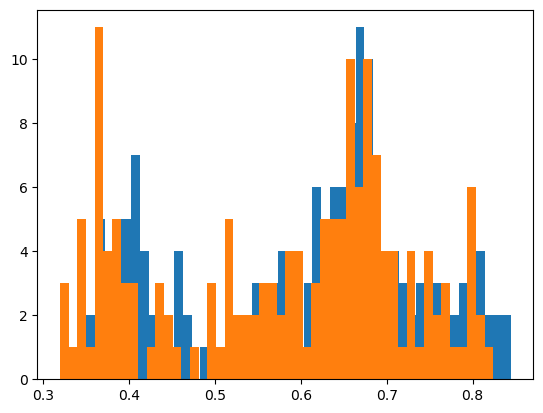

In [12]:
#histogram of distributions
import matplotlib.pyplot as plt
plt.hist(np.array(corrs1)[:,0], bins = 50)
plt.hist(np.array(corrs2)[:,0], bins = 50)
#they are very similar, but it's hard to really tell

In [13]:
#let's do per row now
from tqdm import tqdm
corrs1 = []
corrs2 = []
for i in tqdm(range(treg.shape[0])):
    corr = pearsonr(treg[i,:], preg2[i,:])
    corrs2.append(corr)
    corr = pearsonr(treg[i,:], preg1[i,:])
    corrs1.append(corr)

100%|██████████| 105252/105252 [03:10<00:00, 551.60it/s]


0.23881655294068857
0.2101141809802058


(array([2.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 5.000e+00, 0.000e+00,
        4.000e+00, 4.000e+00, 1.000e+00, 3.000e+00, 7.000e+00, 1.400e+01,
        1.400e+01, 3.200e+01, 5.400e+01, 9.500e+01, 1.900e+02, 3.790e+02,
        5.820e+02, 8.630e+02, 1.285e+03, 1.876e+03, 2.481e+03, 3.142e+03,
        3.940e+03, 4.754e+03, 5.256e+03, 6.001e+03, 6.378e+03, 6.589e+03,
        6.794e+03, 6.817e+03, 6.877e+03, 6.412e+03, 5.758e+03, 5.109e+03,
        3.921e+03, 3.190e+03, 2.760e+03, 2.495e+03, 2.101e+03, 1.920e+03,
        1.708e+03, 1.512e+03, 1.222e+03, 1.085e+03, 7.520e+02, 5.250e+02,
        2.670e+02, 7.300e+01]),
 array([-0.68447229, -0.65128715, -0.61810201, -0.58491687, -0.55173172,
        -0.51854658, -0.48536144, -0.4521763 , -0.41899116, -0.38580602,
        -0.35262088, -0.31943574, -0.2862506 , -0.25306546, -0.21988032,
        -0.18669518, -0.15351004, -0.1203249 , -0.08713976, -0.05395461,
        -0.02076947,  0.01241567,  0.04560081,  0.07878595,  0.11197109,
         0.

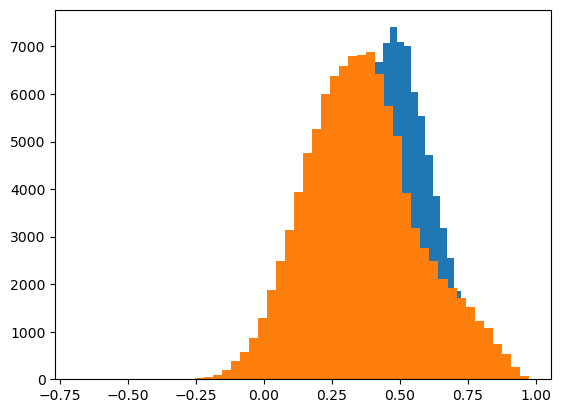

In [14]:
#now let's plot the distributions
print(np.mean(corrs1))
print(np.mean(corrs2))
plt.hist(np.array(corrs1)[:,0], bins = 50)
plt.hist(np.array(corrs2)[:,0], bins = 50)

{'whiskers': [<matplotlib.lines.Line2D at 0x2b3c29e5a290>,
 'caps': [<matplotlib.lines.Line2D at 0x2b3c29e5ba10>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b3c29d95e10>,
 'medians': [<matplotlib.lines.Line2D at 0x2b3c29e42f50>,
 'fliers': [<matplotlib.lines.Line2D at 0x2b3c29e424d0>,
 'means': []}

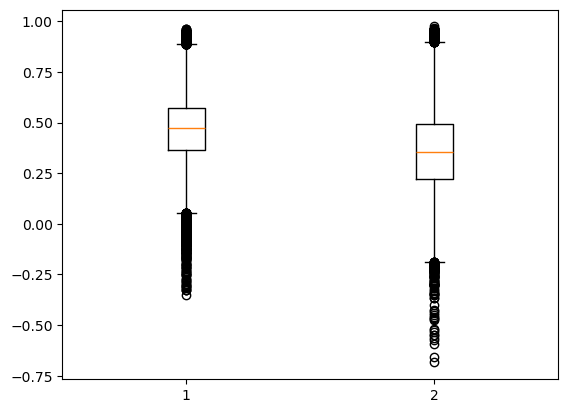

In [15]:
#let's do a boxplot
plt.boxplot([np.array(corrs1)[:,0], np.array(corrs2)[:,0]]) #wow, the first one is much better!

In [16]:
#now we have to consider masking them
mask = treg != -10
preg1_masked = preg1[mask]
preg2_masked = preg2[mask]
treg_masked = treg[mask]
#and print shapes
print(preg1_masked.shape, preg2_masked.shape, treg_masked.shape)

torch.Size([16352624]) torch.Size([16352624]) torch.Size([16352624])


In [17]:
mask.shape

torch.Size([105252, 161])

In [18]:
#just do a correlation on this for now, and isnce it's 1d vectors, should just get a single value
corr1 = pearsonr(treg_masked, preg1_masked)
corr2 = pearsonr(treg_masked, preg2_masked)
print(corr1, corr2) #significantly better for this!! So we know that it's doing better at predicting the other ones!
#that was the hypothesis and this does make sense

PearsonRResult(statistic=0.596312088507674, pvalue=0.0) PearsonRResult(statistic=0.6909049625691586, pvalue=0.0)


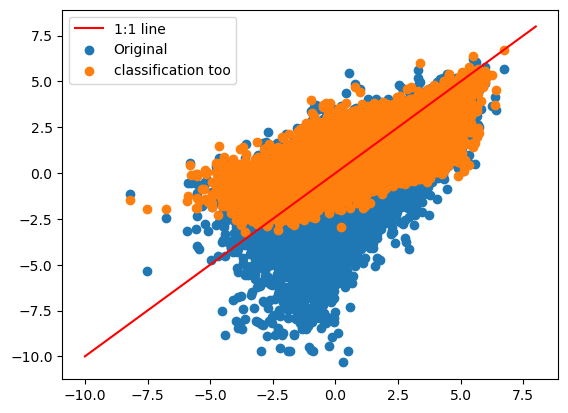

In [23]:
#let's plot this, but we have to sample it because too many points, every 11 should be fine
plt.plot([-10,8],[-10,8], color='red')
plt.scatter(treg_masked[::100], preg1_masked[::100])
plt.scatter(treg_masked[::100], preg2_masked[::100])
#legend
plt.legend(['1:1 line', 'Original', 'classification too'])
#this classification model has no reason to predict -10 values so doesn't even try, makes it more regression to the mean
#worse at smaller values, but equal for larger values and better for middle values

In [24]:
#now let's find a way to do correlations per row
#let's create the masked objects as copies of the original
treg_masked = treg.clone()
preg1_masked = preg1.clone()
preg2_masked = preg2.clone()
#now find values that are -10 in the target
mask = treg == -10
#and replace the mask indices with NaN
treg_masked[mask] = np.nan
preg1_masked[mask] = np.nan
preg2_masked[mask] = np.nan
#print all the shapes
print(treg_masked.shape, preg1_masked.shape, preg2_masked.shape)

torch.Size([105252, 161]) torch.Size([105252, 161]) torch.Size([105252, 161])


In [26]:
print(treg_masked[0])

tensor([        nan, -4.5808e-01,         nan,         nan, -1.8792e+00,
                nan, -2.3478e+00, -1.8173e+00, -6.1973e-01, -3.1970e+00,
        -3.1362e+00, -6.3732e-01,         nan,         nan,         nan,
                nan,         nan,         nan,         nan, -1.6359e+00,
        -2.9812e+00,         nan,         nan, -1.9674e+00,         nan,
                nan,         nan, -1.1343e+00, -1.4971e+00,         nan,
                nan,         nan, -1.6084e+00,         nan,         nan,
        -2.0236e+00, -2.5367e+00, -1.1614e-01, -5.7076e-01,         nan,
                nan,         nan,         nan,         nan,         nan,
        -6.2989e-01,         nan, -3.2462e-01,         nan,         nan,
                nan, -2.0274e-01,         nan, -1.7594e+00,         nan,
        -7.5590e-01, -1.1066e+00, -1.7550e+00,         nan,         nan,
        -1.2859e+00,         nan, -4.0290e-02,         nan, -5.8336e-01,
                nan,         nan,         nan,     

In [31]:
#now let's do it per column
corrs1 = []
corrs2 = []
for i in range(treg_masked.shape[1]):
    #a key is we need to remove the NaN values
    temp_target = treg_masked[:,i]
    #and remove nan
    temp_target = temp_target[~torch.isnan(temp_target)]
    # print(temp_target, temp_target.shape)
    
    # break
    temp_reg1 = preg1_masked[:,i]
    temp_reg1 = temp_reg1[~torch.isnan(temp_reg1)]
    corr = pearsonr(temp_target, temp_reg1)
    corrs1.append(corr)
    temp_reg2 = preg2_masked[:,i]
    temp_reg2 = temp_reg2[~torch.isnan(temp_reg2)]
    corr = pearsonr(temp_target, temp_reg2)
    corrs2.append(corr)
#print the means
print(np.mean(corrs1), np.mean(corrs2)) #only slighlty higher

0.3334134577661768 0.3456259685463429


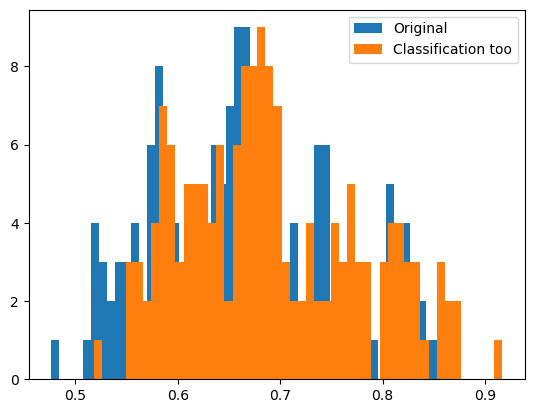

In [33]:
#plot the distribution
plt.hist(np.array(corrs1)[:,0], bins = 50)
plt.hist(np.array(corrs2)[:,0], bins = 50)
#legend
plt.legend(['Original', 'Classification too'])

In [34]:
#and now per row
corrs1 = []
corrs2 = []
for i in tqdm(range(treg_masked.shape[0])):
    #a key is we need to remove the NaN values
    temp_target = treg_masked[i,:]
    #and remove nan
    temp_target = temp_target[~torch.isnan(temp_target)]
    temp_reg1 = preg1_masked[i,:]
    temp_reg1 = temp_reg1[~torch.isnan(temp_reg1)]
    corr = pearsonr(temp_target, temp_reg1)
    corrs1.append(corr)

    temp_reg2 = preg2_masked[i,:]
    temp_reg2 = temp_reg2[~torch.isnan(temp_reg2)]
    corr = pearsonr(temp_target, temp_reg2)
    corrs2.append(corr)

100%|██████████| 105252/105252 [03:20<00:00, 525.90it/s]


0.21928802238523684 0.25967691783175445


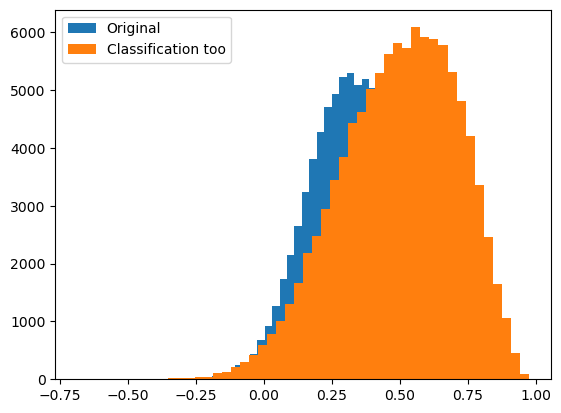

In [35]:
print(np.mean(corrs1), np.mean(corrs2)) #only slighlty higher
#and plot
plt.hist(np.array(corrs1)[:,0], bins = 50)
plt.hist(np.array(corrs2)[:,0], bins = 50)
#legend
plt.legend(['Original', 'Classification too'])

## conclusions
The model that does classification and disregards the -10 points does much better in general because it doesn't usually have to worry about the negative values, this is good and shows the model is actually doing MSE

# evaluating classification
We now evaluate how well it's able to classify the values

In [41]:
#the easy answer is just create a confusion matrix and roc curve for the classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
#let's just do it for all the values together
#first have to take pclass and use 0 as the threshold
pclass_binary = np.where(pclass > 0, 1, 0)
cm = confusion_matrix(tclass.numpy().flatten(), pclass_binary.flatten())
print(cm)

[[   53612   539336]
 [   31841 16320783]]


In [40]:
pclass_binary.shape

(105252, 161)

In [43]:
#normalize cm by dividing by the number of samples
cm_new = cm / np.sum(cm)
print(cm_new)
#most of them are open and can properly predict this, let's see the roc curve

[[0.00316378 0.03182755]
 [0.00187902 0.96312966]]


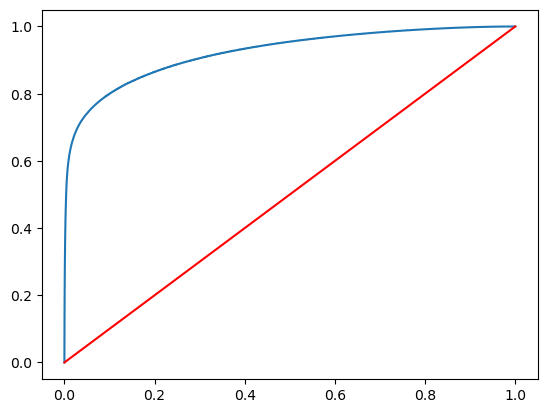

In [44]:
#roc curve now
fpr, tpr, thresholds = roc_curve(tclass.numpy().flatten(), pclass.flatten())
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], color='red')

In [45]:
#and auc
roc_auc_score(tclass.numpy().flatten(), pclass.flatten())

0.9221599384095003

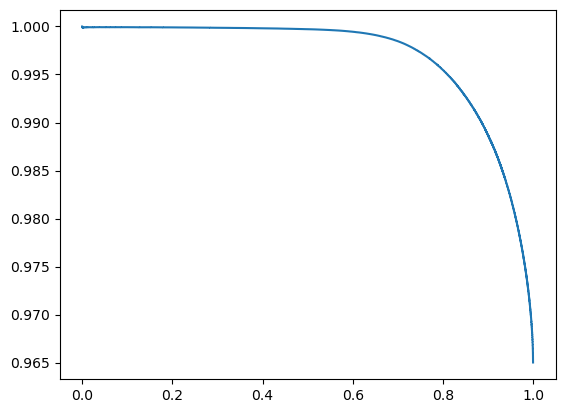

In [46]:
#we can also do precision recall curve
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(tclass.numpy().flatten(), pclass.flatten())
plt.plot(recall, precision)

In [47]:
#and we find the area underneath the curve
from sklearn.metrics import auc
auc(recall, precision) 
#insane precision and recall!!

0.9968743607488747

In [48]:
pclass #yeah that's the sorts of values we'd expect... but why is this so much better than looking one row at a time??

tensor([[1.3113, 1.0276, 2.4768,  ..., 2.2193, 4.1963, 3.7032],
        [0.9108, 1.2559, 2.4030,  ..., 1.1982, 5.6989, 4.1233],
        [2.2807, 2.6887, 3.0480,  ..., 0.8409, 4.6183, 2.5676],
        ...,
        [3.6389, 3.8199, 6.1429,  ..., 2.4347, 7.0609, 6.4253],
        [6.4838, 6.6250, 6.6446,  ..., 2.9762, 8.2959, 6.8535],
        [4.6932, 4.7125, 5.9956,  ..., 2.6815, 7.3133, 6.5013]])

In [49]:
#let's compare one column at a time and find the rocauc and prcauc
auclist = []
prclist = []
for i in range(tclass.shape[1]):
    # fpr, tpr, thresholds = roc_curve(tclass[:,i], pclass[:,i])
    auclist.append(roc_auc_score(tclass[:,i], pclass[:,i]))
    precision, recall, thresholds = precision_recall_curve(tclass[:,i], pclass[:,i])
    prclist.append(auc(recall, precision))
#print the means
print(np.mean(auclist), np.mean(prclist)) #this is much better than the average, but it's still very good

0.8437360357336126 0.987681174542341


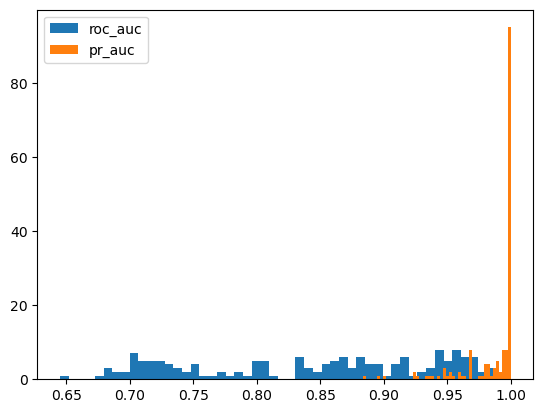

In [51]:
#let's look at the distribution
plt.hist(auclist, bins = 50)
plt.hist(prclist, bins = 50)
plt.legend(['roc_auc', 'pr_auc'])
#actually pretty good!!
#shows that for some cell types pehnomenal

In [54]:
#and by rows
auclist = []
prclist = []
for i in tqdm(range(tclass.shape[0])):
    # fpr, tpr, thresholds = roc_curve(tclass[i,:], pclass[i,:])
    #check to ensure that tclass[i,:] is not all the same 0 or 1 output
    if torch.all(tclass[i,:] == 0) or torch.all(tclass[i,:] == 1):
        continue
    auclist.append(roc_auc_score(tclass[i,:], pclass[i,:]))
    precision, recall, thresholds = precision_recall_curve(tclass[i,:], pclass[i,:])
    prclist.append(auc(recall, precision))

100%|██████████| 105252/105252 [03:11<00:00, 549.86it/s]


87140 87140
0.9139230694689952 0.9950151543557907


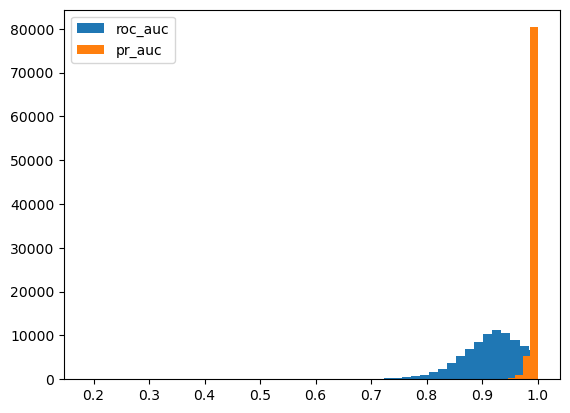

In [56]:
print(len(auclist), len(prclist)) #shoudl be the same length, but skips CREs where all the same
print(np.mean(auclist), np.mean(prclist)) #this is much better than the average, but it's still very good
#and plot them
plt.hist(auclist, bins = 50)
plt.hist(prclist, bins = 50)
plt.legend(['roc_auc', 'pr_auc'])

In [58]:
print(tclass[0,:]) #let's make sure when we manually calculate this we get the exact same results
print(pclass[0,:])
print(auclist[0])
print(prclist[0])
print(roc_auc_score(tclass[0,:], pclass[0,:]))
#and auc of prc
precision, recall, thresholds = precision_recall_curve(tclass[0,:], pclass[0,:])
print(auc(recall, precision)) #both of these line up with our list, now let's manually go ahead and check
#oh seems like this is one of the worst ones, so that makes sense

tensor([0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.])
tensor([ 1.3113,  1.0276,  2.4768,  3.5758,  3.2231,  3.1419,  4.0295,  3.1059,
         2.3982,  3.9641,  3.5131,  1.7574,  1.5665,  3.9942,  3.3422,  1.4613,
         1.6208,  1.8042,  1.1558,  3.8076,  3.3139,  1.6151,  2.5940,  2.3656,
         2.2174,  0.3841,  3.4716,  1.1116,

In [60]:
auclist[:100] #enhancers seem to be the worst ones lmfao!!

[0.6440387016229713,
 0.8085271317829457,
 0.8461968680089484,
 0.7760536398467432,
 0.5701754385964912,
 0.8089171974522293,
 0.9654088050314465,
 0.9792993630573248,
 1.0,
 0.93125,
 0.8666666666666667,
 0.9276729559748428,
 0.9517543859649122,
 0.8634596695821185,
 0.9271523178807948,
 0.9559748427672956,
 0.9937106918238994,
 0.9666666666666667,
 0.9612903225806452,
 0.9591194968553459,
 0.9808917197452229,
 0.9811320754716981,
 0.9156050955414012,
 1.0,
 0.9472573839662447,
 0.9580645161290323,
 0.9763071895424836,
 0.89375,
 0.8301886792452831,
 0.9721706864564007,
 0.9562913907284769,
 0.9506237006237005,
 0.9463576158940397,
 0.9704641350210971,
 0.8794063079777366,
 0.9251592356687899,
 0.9782051282051282,
 0.9591397849462366,
 0.9793939393939394,
 0.9598173515981735,
 0.9473118279569892,
 0.9390380313199104,
 0.9746835443037976,
 0.975,
 0.9559748427672956,
 0.88125,
 0.9012820512820513,
 0.9535864978902954,
 0.8754310344827587,
 0.9397435897435898,
 0.9692982456140351,
 0.95

In [65]:

import torch 
import sys
import yaml 
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
from src.tasks.decoders import SequenceDecoder
from src.models.sequence.dna_embedding import DNAEmbeddingModel
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
# import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logomaker
from tqdm import tqdm

#TODO there are many NotImplementedErrors that need to be fixed, search for self.dataset to see where it's used and fix it
#TODO there is one difference based on the opposite signs function that is in shap_testing5, but not in the actual ism_utils.py, copy paste it

class ISMUtils():
    def __init__(self, model_type, ckpt_path, cfg = None, split = 'train', filter=True):
        type_list = ['ccre', 'DNase_ctst', 'DNase_allcelltypes', 'DNase']
        if model_type not in type_list:
            raise ValueError('Model type not recognized')
        self.mtype = model_type
        if cfg is not None:
            cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/'+cfg
        
        #check to see the type, and then load the right tokenizer, class and cfg
        if self.mtype == 'DNase':
            from src.dataloaders.datasets.DNase_dataset import DNaseDataset as DatasetClass
            self.tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            if cfg is None:
                cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase.yaml'
                
        elif self.mtype == 'DNase_allcelltypes':
            from src.dataloaders.datasets.DNase_allcelltypes import DNaseAllCellTypeDataset as DatasetClass
            self.tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            if cfg is None:
                cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_allcelltypes.yaml'

        elif self.mtype == 'DNase_ctst':
            from src.dataloaders.datasets.DNase_ctst_dataset import DNaseCtstDataset as DatasetClass
            self.tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            if cfg is None:
                cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_ctst.yaml'

        else:
            raise ValueError('Model type not recognized')

        #now we load the model and dataset

        # self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.dataset = DatasetClass(max_length = 1024, split = split, tokenizer=self.tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True', filter = filter)
        cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
        
        train_cfg = cfg['train']  # grab section `train` section of config
        model_cfg = cfg['model_config']  # grab the `model` section of config
        d_output = train_cfg['d_output']
        backbone = DNAEmbeddingModel(**model_cfg)
        # backbone_skip = DNAEmbeddingModel(skip_embedding=True, **model_cfg)
        decoder = SequenceDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')
        state_dict = torch.load(ckpt_path, map_location='cpu')  # has both backbone and decoder
        
        # loads model from ddp by removing prexix to single if necessary
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )

        model_state_dict = state_dict["state_dict"]

        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)

        # the state_dict keys slightly mismatch from Lightning..., so we fix it here
        decoder_state_dict = {}
        decoder_state_dict['output_transform.weight'] = model_state_dict.pop('decoder.0.output_transform.weight')
        decoder_state_dict['output_transform.bias'] = model_state_dict.pop('decoder.0.output_transform.bias')

        #now adjust the backbone if needed
        if self.mtype == 'DNase':
            embedding1 = torch.nn.Embedding(20, 128)
            # embedding2 = torch.nn.Embedding(20, 128)
            backbone.backbone.embeddings.word_embeddings = embedding1 #again a hack
            # backbone_skip.backbone.embeddings.word_embeddings = embedding2 #again a hack

        # now actually load the state dict to the decoder and backbone separately
        decoder.load_state_dict(decoder_state_dict, strict=True)
        backbone.load_state_dict(model_state_dict, strict=True)

        self.backbone = backbone.eval()
        self.decoder = decoder.eval()

        self.bed = pd.read_csv('/data/leslie/sarthak/data/GRCh38-cCREs.bed', header=None, delimiter='\t').to_numpy()
        self.middle = 1023//2 #just used for the logo plots

    def calculate_ISM(self,ccre, cuda = False, return_out = False, progress_bar = False):
        #does ISM for that ccre, based on the model type
        #Does what the ISM.py and ISM_allcelltypes.py files do but for one ccre at a time
        #ccre should be the index of the ccre, not the index to get that dataset
        device = "cuda:0" if cuda else "cpu"
        backbone = self.backbone.to(device)
        decoder = self.decoder.to(device)
        #first have to load in the batch
        #if it's the different groups have very different dataset classes
        if self.mtype == 'DNase' or self.mtype == 'DNase_ctst':
            ccre = 161*ccre
            ccre_list = []
            out_list = []
            for i in range(161):
                a,b = self.dataset[ccre+i]
                ccre_list.append(a)
                if isinstance(b,tuple):
                    raise NotImplementedError('This is not implemented yet, need to consider how to do ISM with the classification model')
                out_list.append(b.item())
            ccre_list = torch.stack(ccre_list)
        else:
            ccre_list = self.dataset[ccre][0].unsqueeze(0)

        temp,_ = backbone(ccre_list.to(device))
        out = decoder(temp)

        out_gt_np = out.detach().cpu().numpy().reshape(1, 1, 161) #the initial output of the model before ism
        
        #now we can calculate the ISM
        #we add someway to return the output of the model as well if we want to
        ISM_results = np.ones((4,1023,161))*out_gt_np
        if self.mtype == 'DNase_ctst':
            ISM_results = np.ones((4,1024,161))*out_gt_np #because is full 1024 sequence length...
        if self.mtype == 'DNase' or self.mtype == 'DNase_ctst':
            seq = ccre_list[0]
        else:
            seq = ccre_list.squeeze()
        token_list = [7,8,9,10] #tokenize this list first

        if progress_bar:
            iterator = tqdm(enumerate(seq), total = len(seq))
        else:
            iterator = enumerate(seq)
        with torch.no_grad():
            for idx, nucleotide in iterator: 
                temp_token_list = token_list.copy() #we make a copy
                # print(nucleotide)
                if nucleotide not in temp_token_list:
                    continue #basically skips this and none of it is updated, because is a weird tooken, whether permutation, ctst or something else
                temp_token_list.remove(nucleotide)
                temp_token_list = np.array(temp_token_list)
                results_list = []
                for j in temp_token_list:
                    temp_seq = ccre_list.clone() #never put on the gpu
                    if self.mtype == 'DNase' or self.mtype == 'DNase_ctst':
                        temp_seq[:,idx] = j
                    else:
                        temp_seq[idx] = j
                    a,_ = backbone(temp_seq.to(device))
                    out = decoder(a)
                    results_list.append(out.detach().cpu().numpy())
                ISM_results[temp_token_list-7,idx,:] = np.array(results_list).squeeze()
        #relatively slow on the CPU
        #and now we subtract the out_gt from it
        ISM_results_normalized = ISM_results - out_gt_np #is mutated - reference
        
        if return_out: #but this is optional
            return ISM_results_normalized, out_gt_np
        return ISM_results_normalized

    def var(self, idx):
        #This is the idx for the ccre, so if you want it for ccre 2 it's just idx == 2. Not 161*idx
        seq_idx = idx
        cCRE_id = self.dataset.array[seq_idx][0] #get the id from the array
        row = self.dataset.cCRE_dict[cCRE_id]
        #now we can calculate the variance using this data
        # print(np.var(dnase_filtered[row,:])) #identical
        
        return np.var(self.dataset.cell_dnase_levels[row,:])

    def output(self,idx):
        #given the index, this finds the associated output (single value)
        #this literally just puts it thorugh the model, but it's like 2 lines of code and really easy to do yourself
        a,b = self.dataset[idx]
        temp,_ = self.backbone(a.unsqueeze(0))
        out = self.decoder(temp)

        if self.mtype == 'DNase':
            print(f'predicted output: {out}, actual output: {b}')
            return b, out

        elif self.mtype == 'DNase_allcelltypes':
            print(f'predicted output: {out[0,0]}, actual output: {b[0]}')
            return b[0], out[0,0]

    def output_all(self,idx):
        #given the index, this finds the associated output (all values averaged across the cell types for a singel ccre)
        #if it's DNase, then we need to do it for all the cell types, here the input idx should not be 161 times any number, rather just the ccre number
        if self.mtype == 'DNase' or self.mtype == 'DNase_ctst':
            idx = 161*idx
            out_list = []
            target_list = []
            for i in range(161):
                a,b = self.dataset[idx+i]
                temp,_ = self.backbone(a.unsqueeze(0))
                out = self.decoder(temp)
                out_list.append(out.item())
                if isinstance(b,tuple):
                    raise NotImplementedError('This is not implemented yet, need to consider how to do handle these outputs and what we want to display')
                target_list.append(b.item())
            out = np.mean(out_list)
            print(f'predicted output mean: {out}, actual output mean: {np.mean(target_list)}')
            #but return the whole lists
            return np.array(target_list), np.array(out_list)

        if self.mtype == 'DNase_allcelltypes':
            a,b = self.dataset[idx]
            temp,_ = self.backbone(a.unsqueeze(0))
            out = self.decoder(temp)
            print(f'predicted output mean: {torch.mean(out)}, actual output mean: {torch.mean(b)}')
            return b.detach().numpy(), out.detach().numpy()

    def plot_singlecelltype(self, data, celltype = 0):
        #given the index, this finds the associated output (single value)
        #we can either take in the actual data, or the ccre number
        #actual data must be formatted the same as the saved data
        if type(data) == int:
            data_loaded = np.load(f'/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/saved_ISM/ISM_run1_normalized_{data}.npy')
        elif type(data) == np.ndarray: #you can also just give it the data and then it doesn't need to load it
            data_loaded = data
        fig, ax = plt.subplots(1,1, figsize = (20,10))
        sns.heatmap(data_loaded[:,:,celltype], cmap = 'seismic', center = 0)
        plt.yticks([0.5,1.5,2.5,3.5],['A','C','G','T'])
        plt.xlabel('sequence position')
        plt.title(f'ISM scores for the {celltype} cell type of the {data} ccre')
        plt.show()

    def plot_all(self,data):
        #once again can give the ccre or the actual data
        if type(data) == int:
            data_loaded = np.load(f'/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/saved_ISM/ISM_run1_normalized_{data}.npy')
        elif type(data) == np.ndarray:
            data_loaded = data
        fig, ax = plt.subplots(1,1, figsize = (20,10))
        sns.heatmap(data_loaded.sum(axis = 0).T, cmap = 'seismic', center = 0)
        plt.ylabel('celltype')
        plt.xlabel('sequence position')
        plt.title('ISM scores for all cell types single ccre')
        plt.show()

    def default_heights(self,data):
        #it will sum across the nucelotides and average over the celltypes
        if type(data) == int:
            data_loaded = np.load(f'/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/saved_ISM/ISM_run1_normalized_{data}.npy')
        elif type(data) == np.ndarray:
            data_loaded = data
        return data_loaded.sum(axis = 0).mean(axis = 1)

    def logoplot(self,ccre,heights = None, startend=None,flip_heights = False): #potentially we add the title as an input into the model
        #so given the ccre number and the heights, this will plot the logo plot
        #note ccre should be the ccre number regardless of the model type
        #heights must be provided, is usually the sum across the axis=1 for the data that is used for plot_all, uses same start and end
        if self.mtype == 'DNase' or self.mtype == 'DNase_ctst':
            ccre = 161*ccre
        a,b = self.dataset[ccre]
        seq=self.dataset.tokenizer.decode(a)
        if startend is None and self.mtype == 'DNase':
            start = self.middle-50+4
            end = self.middle+50+4
        elif startend is None and self.mtype == 'DNase_allcelltypes':
            start = self.middle-50
            end = self.middle+50
        elif self.mtype == 'DNase': #if specify it, add 4 to the dnase, just so aligns with the multitasking model
            start = startend[0]+4
            end = startend[1]+4
        elif self.mtype == 'DNase_ctst':
            start = startend[0]+1
            end = startend[1]+1
        else:
            start = startend[0]
            end = startend[1]

        #now we can define cut_seq
        cut_seq = seq[start:end]
                    
        if heights is None:
            raise ValueError('Need to provide heights')

        #now we define cut heights
        heights = heights[start:end]
        if flip_heights:
            heights = -heights
        logo_df = pd.DataFrame(0, index=np.arange(len(cut_seq)), columns=list(set(cut_seq)), dtype=float)

        # Fill the DataFrame with heights, converting heights to float if necessary
        for i, symbol in enumerate(cut_seq):
            logo_df.loc[i, symbol] = heights[i]

        # Generate the sequence logo
        # fig, ax = 
        # fig.set_size_inches(20, 3)  # Set the desired width and height here        
        logo = logomaker.Logo(logo_df, color_scheme='classic', flip_below = True, figsize = (20,3))
        plt.title('Sequence logo')
        # fig.show()
    
    def find_ccre_type(self, idx):
        #this function will use the ccre id to find the specific type
        #uses the index of the dataset, not the cCRE for the DNase model!!
        #first get the id
        if self.mtype == 'DNase':        
            seq_idx = int(idx/self.dataset.cell_types)
        else:
            seq_idx = idx
        ccre_id = self.dataset.array[seq_idx][0]
        line = np.where(self.bed[:,3] == ccre_id)
        return self.bed[line[0][0], -1]
ckpt = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-23/09-35-33-196632/checkpoints/381-val_loss=3.57483.ckpt'
ism = ISMUtils('DNase_allcelltypes', ckpt, filter=True, split='test')

In [67]:
ism.find_ccre_type(0)

'DNase-H3K4me3,CTCF-bound'

In [72]:
for i in range(10):
    print(ism.find_ccre_type(i), auclist[i])

DNase-H3K4me3,CTCF-bound 0.6440387016229713
dELS 0.8085271317829457
dELS,CTCF-bound 0.8461968680089484
CTCF-only,CTCF-bound 0.7760536398467432
CTCF-only,CTCF-bound 0.5701754385964912
pELS,CTCF-bound 0.8089171974522293
pELS 0.9654088050314465
pELS 0.9792993630573248
pELS 1.0
pELS,CTCF-bound 0.93125


In [73]:
#amazing on some of these proximal enhancer like sequences!!
#let's now find the pearsonr for the first 10 rows
corrs1 = []
corrs2 = []
for i in range(10):
    corr = pearsonr(treg[i,:], preg2[i,:])
    corrs2.append(corr)
    corr = pearsonr(treg[i,:], preg1[i,:])
    corrs1.append(corr)

In [75]:
for i in range(10):
    print(ism.find_ccre_type(i), auclist[i], corrs1[i].statistic, corrs2[i].statistic)
#see that it's not the best relationship, but generally when better at predicting the other ones, it's better at predicting the DNase, wait that's
#with the whole non masked one, that's not good, should consider mask... oh well!
#the kernel ended, could do it later, but the point is we want to do it on the training data anyways

DNase-H3K4me3,CTCF-bound 0.6440387016229713 0.34016903825646594 0.2228108035208005
dELS 0.8085271317829457 0.580221444553118 0.3701492008487959
dELS,CTCF-bound 0.8461968680089484 0.38995398467282516 0.23009318424334008
CTCF-only,CTCF-bound 0.7760536398467432 0.16928319218856663 0.2991806629476228
CTCF-only,CTCF-bound 0.5701754385964912 0.15028117236617997 0.19685424558692044
pELS,CTCF-bound 0.8089171974522293 0.19717566552606441 0.1434035177298844
pELS 0.9654088050314465 0.5014363965343012 0.42173735721018385
pELS 0.9792993630573248 0.538314919574546 0.3249080003170075
pELS 1.0 0.5483675022251822 0.5866514410341183
pELS,CTCF-bound 0.93125 0.5285477976116271 0.4553639655638356


# testing to see if my evaluation is correct

In [1]:
#let's take in the data and see if we can manually take the outputs and see if we truly get such a good classification accuracy
#for now stick to multitasking model
import torch
from evals.evals_utils import Evals

multitasking_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-03-20/22-26-03-326937/checkpoints/138-val_loss=0.37743.ckpt'

eval_multitasking = Evals('DNase_allcelltypes',multitasking_path, classification=True)
targets,predicts = eval_multitasking.evaluate(num_workers = 1, batch_size = 512, stop=10)
targets_class,targets_reg = targets
predicts_class,predicts_reg = predicts
print(targets_class.shape, targets_reg.shape, predicts_class.shape, predicts_reg.shape)
#one worker basic gpu takes like 2.5 minutes to evaluate the model, easy!

100%|██████████| 206/206 [01:19<00:00,  2.61it/s]

torch.Size([105252, 161]) torch.Size([105252, 161]) torch.Size([105252, 161]) torch.Size([105252, 161])


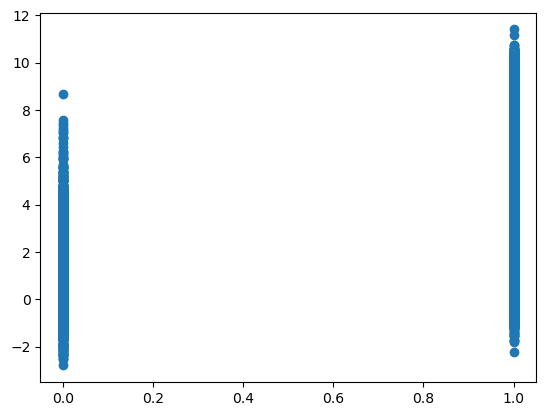

In [2]:
#an easy answer is let's plot some of the targets_class and predicts_class on a scatterplot
import matplotlib.pyplot as plt
plt.scatter(targets_class.flatten()[::100], predicts_class.flatten()[::100])
#hard to tell why it would actually be so good...

{'whiskers': [<matplotlib.lines.Line2D at 0x2b68c9980710>,
 'caps': [<matplotlib.lines.Line2D at 0x2b68c9abe890>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b68bfc83c90>,
 'medians': [<matplotlib.lines.Line2D at 0x2b68c9abfa10>,
 'fliers': [<matplotlib.lines.Line2D at 0x2b68c9ad8250>,
 'means': []}

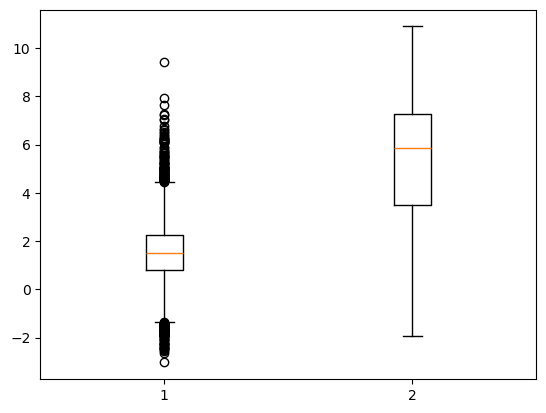

In [5]:
#let's do a boxplot of the two groups
group1 = targets_class.flatten()==0
group2 = targets_class.flatten()==1
#now do the boxplot of the predicts_class with those masks
plt.boxplot([predicts_class.flatten()[group1][::100], predicts_class.flatten()[group2][::100]])

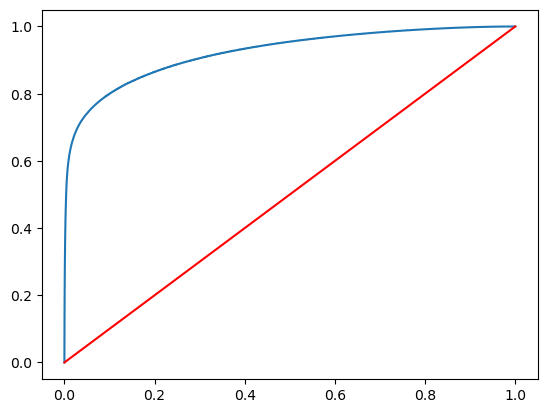

In [7]:
#now let's do the auc curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds = roc_curve(targets_class.flatten(), predicts_class.flatten())
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], color='red')
#not ideal since correlation in my model

In [8]:
#let's find the auc score
roc_auc_score(targets_class.flatten(), predicts_class.flatten())

0.9221599384095003

In [10]:
#let's manually calculae the area under the curve for this
print(fpr.shape,tpr.shape)
print(targets_class.shape[0]*targets_class.shape[1]) #much more here, like 3x the number of points 

(5855281,) (5855281,)
16945572


In [12]:
import numpy as np
np.trapz(tpr, fpr) #the exact same area... so let's make sure I am finding roc correctly

0.9221599384095003

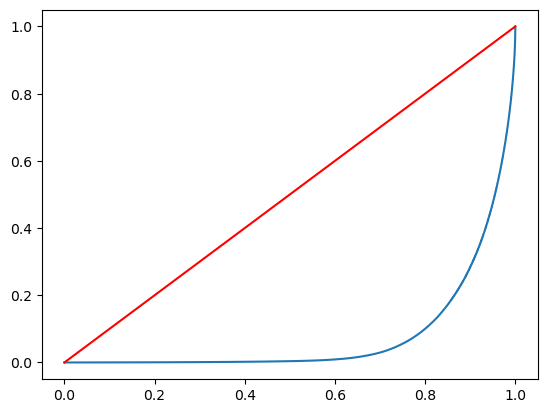

In [28]:
#redo roc curve with the pos_label=0
fpr, tpr, thresholds = roc_curve(targets_class.flatten(), predicts_class.flatten(), pos_label=0)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], color='red')

In [29]:
#and now do auc
roc_auc_score(targets_class.flatten(), predicts_class.flatten(), pos_label=0) #this is the same as the other one, so it's the same

TypeError: got an unexpected keyword argument 'pos_label'

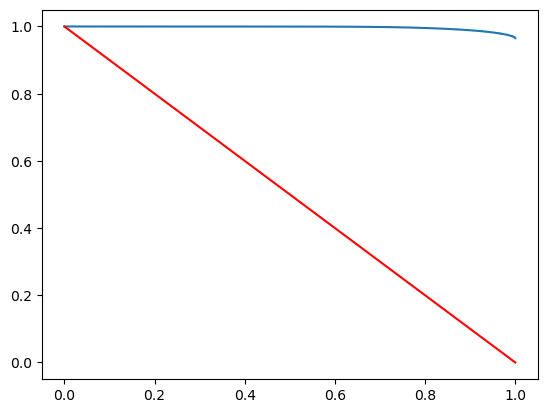

In [14]:
#let's now find the prc
from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import auc
precision, recall, thresholds = precision_recall_curve(targets_class.flatten(), predicts_class.flatten())
plt.plot(recall, precision)
plt.plot([0,1],[1,0], color='red')

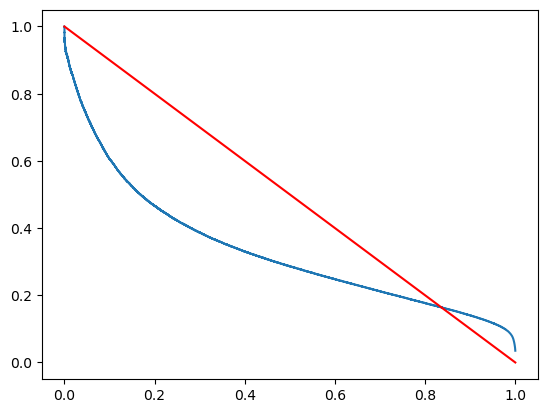

In [15]:
#let's swap the positive and negative and see how the curve is now
temp_label = np.abs(targets_class.flatten()-1)
temp_targets = -predicts_class.flatten()
precision,recall,thresholds = precision_recall_curve(temp_label, temp_targets)
plt.plot(recall, precision)
plt.plot([0,1],[1,0], color='red')

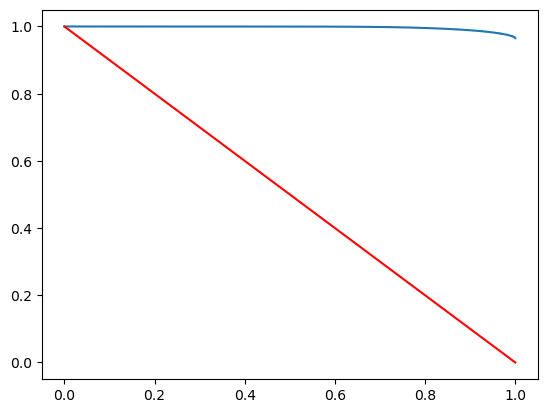

In [18]:
#and if we just swap the labels
precision, recall, thresholds = precision_recall_curve(targets_class.flatten(), predicts_class.flatten(), pos_label=1) #this is the normal one
plt.plot(recall, precision)
plt.plot([0,1],[1,0], color='red')

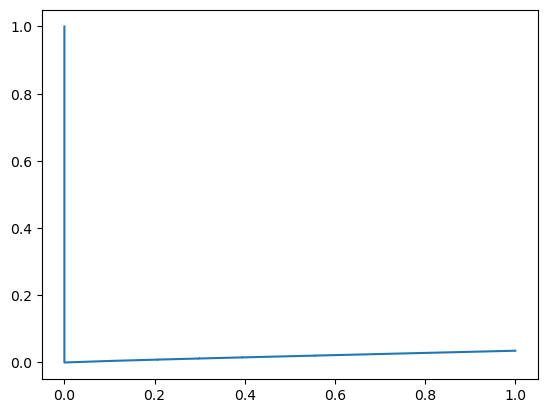

In [24]:
precision, recall, thresholds = precision_recall_curve(targets_class.flatten(), predicts_class.flatten(), pos_label=0) #this is the normal one
plt.plot(recall, precision)
# plt.plot([0,1],[1,0], color='red')

In [25]:
#now use auc to find the auc
from sklearn.metrics import auc
auc(recall, precision) #this is terrible of .02... but it's because the model is so good at predicting the positive class, not really the other way...
#we could bias the model and not use basic CE loss?? do with multitasking model since it's so much faster

0.018350445140178997

In [27]:
#let's find how many values of target_class are 0
num0 = torch.sum(targets_class==0)
num0 #ahh this is the number of thresholds!

tensor(592948)

In [30]:
numelem = torch.numel(targets_class)
numelem

16945572

In [31]:
num0/numelem #only 3.5% are closed... uh oh

tensor(0.0350)

In [33]:
eval_multitasking.dataset.cell_dnase_levels.shape

(1063878, 161)

In [36]:
#find how many of these are 0
num0 = np.sum(eval_multitasking.dataset.cell_dnase_levels==-10)
print(num0)
#that is 6.5 million...
num0/numelem #now it's like 40%?? that's correct, what is going on with my labels

6471895


0.38192248688920033

In [37]:
num0 = torch.sum(targets_reg==-10)
num0

tensor(592948)

In [39]:
#oh wait, we're only looking at the test data, yes for the test data there's way less elements
#let's find it for the celldnaselevels matrix
num0 = np.sum(eval_multitasking.dataset.cell_dnase_levels==-10)
print(num0)
numelem = np.prod(eval_multitasking.dataset.cell_dnase_levels.shape)
print(numelem)
print(num0/numelem)
#this percentage seems more accurate!!

6471895
171284358
0.037784506860807456
